**I. Introduction**

Since developers typically do not know they are writing incorrect software, there is always the question of whether the change they just made has introduced a bug. A bug in the source code leads to an unintended state within the software, and this corrupted state eventually results in an undesired behavior. This is logged in a bug report message in a change tracking system, frequently surfacing months after the initial bug injection. By the time a developer receives the bug report, they must spend time to familiarize themselves with the source code and the recent changes to it.

This serves as the motivation for designing a bug classification mode, a tool to predict whether a change was buggy or clean after it has been made.

**Processing Steps**
- Loading dataset
- Exploring dataset
- Data Analysis
- Setting up the dataframe
- Creating training and test dataset
- Model Building
- Evaluating model performance
- Making predictions using test dataset
- Comparing model performance using Codescene

**Note that the data has already been prepared and processed before this notebook. Below is the collection of features that were selected to examine the characteristics of buggy and non buggy changes.

<div style="display: flex; flex-wrap: wrap; gap: 80px; justify-content: center;">
  <table>
    <caption><strong>Peer Review Data</strong></caption>
    <tr><th>Feature</th><th>Description</th></tr>
    <tr><td>Number of Reviewers</td><td>Number of reviewers for that change</td></tr>
    <tr><td>Number of Review Comments</td><td>Number of comments left by reviewers</td></tr>
    <tr><td>Number of Review Bug Issues</td><td>Number of reviews that identified bug issues</td></tr>
    <tr><td>Number of Review Comment Issues</td><td>Number of reviews that identified comment issues</td></tr>
    <tr><td>Number of Review Style Issues</td><td>Number of reviews that identified style issues</td></tr>
  </table>

  <table>
    <caption><strong>Change Data</strong></caption>
    <tr><th>Feature</th><th>Description</th></tr>
    <tr><td>Change Complexity</td><td>**</td></tr>
    <tr><td>Number of Formal Patchset</td><td>**</td></tr>
    <tr><td>Number of Draft PatchSet</td><td>""</td></tr>
    <tr><td>Number of PatchSets with Build Failure</td><td>**</td></tr>
    <tr><td>Number of Trial Tests Failed</td><td>**</td></tr>
    <tr><td>Number of Tier One Tests Failed</td><td>**</td></tr>
    <tr><td>Lines of Code Deleted</td><td>**</td></tr>
    <tr><td>Lines of Code Added</td><td>**</td></tr>
  </table>

  <table>
    <caption><strong>Cycle Time Data</strong></caption>
    <tr><th>Feature</th><th>Description</th></tr>
    <tr><td>Days In Progress</td><td>The number of days a change held the status 'in progress'</td></tr>
    <tr><td>Days In Draft</td><td>The number of days a change held the status 'in draft'</td></tr>
    <tr><td>Days In Code Review</td><td>The number of days a change was in code review</td></tr>
  </table>

  <table>
    <caption><strong>Diffusion</strong></caption>
    <tr><th>Feature</th><th>Description</th></tr>
    <tr><td>Number of components</td><td>The number of components within a change</td></tr>
    <tr><td>Number of cpp changed</td><td>The number of files with the extension '.cpp' changed</td></tr>
  </table>

  <table>
    <caption><strong>File History</strong></caption>
    <tr><th>Feature</th><th>Description</th></tr>
    <tr><td>Number of developers</td><td>The number of authors/developers working on that specific change</td></tr>
    <tr><td>Number of unique changes</td><td>**</td></tr>
    <tr><td>Number of file clusters</td><td>Clusters of files that historically tend to change together</td></tr>
    <tr><td>Average age</td><td>The average time interval between the current and the last time the files were modified in each change</td></tr>
  </table>

  <table>
    <caption><strong>Developer Experience</strong></caption>
    <tr><th>Feature</th><th>Description</th></tr>
    <tr><td>Previous Experience</td><td>The number of changes made by the developer before their most recent one</td></tr>
    <tr><td>Recent Experience</td><td>The number of changes made by the developer before their most recent one, weight by age. More recent changes will have a higher weight and  vice versa</td></tr>
    <tr><td>Component Experience</td><td>The number of changes made by the developer to the component before their most recent one</td></tr>
  </table>
  
</div>

**Step 0. Imports**

In [1]:
# importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

**Step 1. Loading the Data**

In [37]:
# reading data

**1.1 Data Validation**

- Type checking
- Missing values check

In [3]:
#Type checking: verifiying that all the data types are correctly enforced
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16439 entries, 0 to 16438
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ChangeID                16439 non-null  int64  
 1   IssueID                 16439 non-null  int64  
 2   ReviewID                16439 non-null  int64  
 3   IssueKey                16439 non-null  object 
 4   NumReviewers            16439 non-null  int64  
 5   NumReviewComments       16439 non-null  int64  
 6   NumBugReviewIssues      16439 non-null  int64  
 7   NumCommentReviewIssues  16439 non-null  int64  
 8   NumStyleReviewIssues    16439 non-null  int64  
 9   NumFormalPatchSet       16439 non-null  int64  
 10  NumDraftPatchSet        16439 non-null  int64  
 11  NumTrialFailed          16439 non-null  int64  
 12  NumTierOneFailed        16439 non-null  int64  
 13  LOCAdded                16439 non-null  int64  
 14  LOCDeleted              16439 non-null

In [4]:
# Missing values check: verifying that there are no NULL values in our dataset
for col in df.columns: 
    miss = df[col].isnull().sum() 
    if miss>0: 
        print("{} has {} missing value(s)".format(col,miss)) 
print('no missing values!')

no missing values!


**Step 2. Exploring our dataset**

- Dataframe shape
- head and tail
- value counts
- describe

In [5]:
# getting the shape 
df.shape

(16439, 29)

In [8]:
df.columns

Index(['ChangeID', 'IssueID', 'ReviewID', 'IssueKey', 'NumReviewers',
       'NumReviewComments', 'NumBugReviewIssues', 'NumCommentReviewIssues',
       'NumStyleReviewIssues', 'NumFormalPatchSet', 'NumDraftPatchSet',
       'NumTrialFailed', 'NumTierOneFailed', 'LOCAdded', 'LOCDeleted',
       'DaysInProgress', 'DaysInDraft', 'DaysInCodeReview', 'NumComponents',
       'NumCppChanged', 'Entropy', 'NumDevelopers', 'NumUniqueChanges',
       'AverageAge', 'PreviousExperience', 'RecentExperience',
       'ComponentExperience', 'numclusters', 'label'],
      dtype='object')

In [9]:
# Counting how many changes led to bugs vs how many changes were clean
value_counts = df['label'].value_counts()
value_counts

label
0    13088
1     3351
Name: count, dtype: int64

In [10]:
df.describe()

,ChangeID,IssueID,ReviewID,NumReviewers,NumReviewComments,NumBugReviewIssues,NumCommentReviewIssues,NumStyleReviewIssues,NumFormalPatchSet,NumDraftPatchSet,...,NumCppChanged,Entropy,NumDevelopers,NumUniqueChanges,AverageAge,PreviousExperience,RecentExperience,ComponentExperience,numclusters,label
count,16439.000000,1.643900e+04,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,...,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000,16439.000000
mean,56195.859663,8.795215e+05,125410.181763,8.391508,5.483910,0.063690,0.315165,5.483910,7.066002,0.812884,...,6.097573,0.930964,39.125373,102.595353,29.311819,14.875722,10.664968,10.498145,17.507878,0.203845
std,20047.662735,1.055687e+05,23145.531043,8.428468,12.342413,0.342858,0.755244,12.342413,7.477400,2.752168,...,80.156399,1.214761,54.495717,249.952286,57.131953,20.895590,13.142663,19.694676,66.870709,0.402867
min,14309.000000,3.694320e+05,69311.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39640.000000,7.998230e+05,107248.000000,4.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55063.000000,8.686690e+05,124834.000000,6.000000,1.000000,0.000000,0.000000,1.000000,5.000000,0.000000,...,1.000000,0.439497,20.000000,33.000000,10.000000,7.000000,6.500000,3.000000,8.000000,0.000000
75%,70073.500000,9.545590e+05,141619.000000,10.000000,5.000000,0.000000,0.000000,5.000000,9.000000,0.000000,...,4.000000,1.576951,56.000000,120.000000,32.000000,21.000000,16.000000,13.000000,18.000000,0.000000
max,103445.000000,1.120511e+06,177104.000000,154.000000,231.000000,18.000000,18.000000,231.000000,133.000000,51.000000,...,6053.000000,12.123470,781.000000,10719.000000,1215.000000,148.000000,85.416667,465.000000,2806.000000,1.000000



**Step 3. Data Analysis**

([<matplotlib.patches.Wedge at 0x245636711d0>,
 [Text(0.25320461188709326, -1.0704613138825272, 'Clean'),
  Text(-0.27622303663846787, 1.1677760204894705, 'Buggy')],
 [Text(0.13811160648386903, -0.5838879893904694, '79.6%'),
  Text(-0.16113010470577288, 0.6812026786188576, '20.4%')])

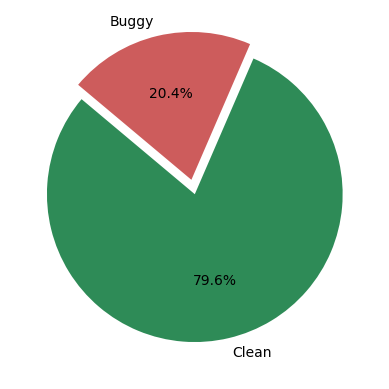

In [31]:
# data is never perfect. visualizing the imbalance of our dataset with a pie chart
label_counts = df['label'].value_counts()
label_mapping = {0: 'Clean', 1: 'Buggy'}
named_labels = label_counts.index.map(label_mapping)
explode = (0, 0.1)
plt.pie(label_counts, labels=named_labels, autopct='%1.1f%%', colors=['seagreen', 'indianred'], startangle=140, explode=explode)

- **Synthesis:** As shown in the pie chart, the dataset is highly imbalanced. There are many more clean changes to work with than buggy changes.

This will impact our model's performance, especially in predicting the minority class (buggy 1).

**3.1 Peer Review Data**

<Axes: xlabel='NumStyleReviewIssues', ylabel='Probability'>

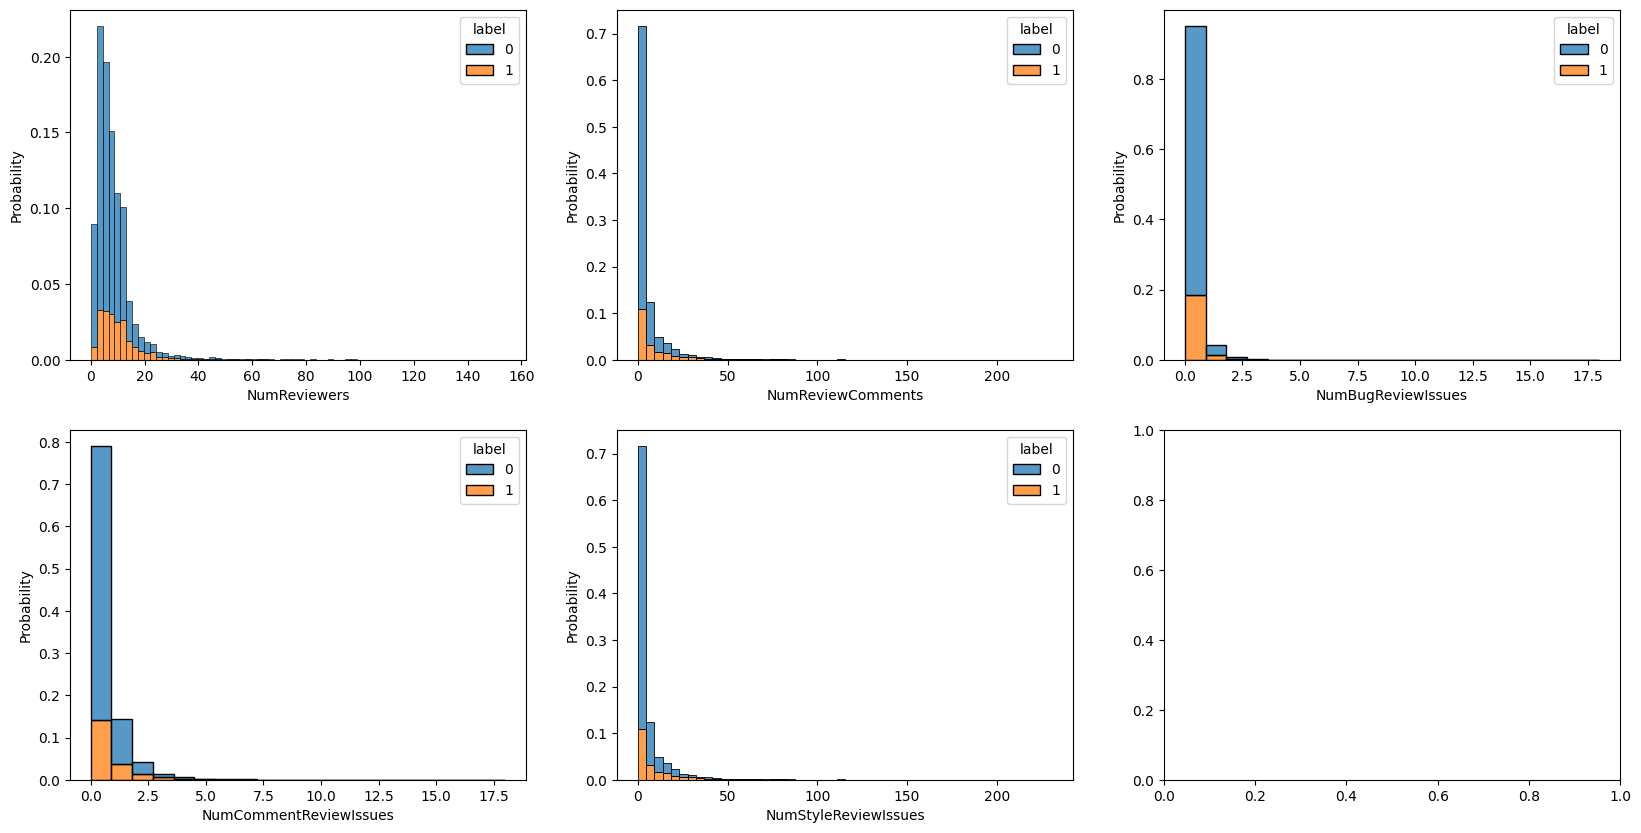

In [32]:
# Now, visualizing peer review features individually against the label feature
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(data=df, x='NumReviewers', bins=70, ax=axes[0, 0], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='NumReviewComments', bins=50, ax=axes[0, 1], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='NumBugReviewIssues', bins=20, ax=axes[0, 2], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='NumCommentReviewIssues', bins=20, ax=axes[1, 0], hue="label", multiple="stack",stat='probability')
sns.histplot(data=df, x='NumStyleReviewIssues', bins=50, ax=axes[1, 1], hue="label", multiple="stack", stat='probability')

- **Synthesis:** Looking at the graphs, we can see that all of the features are highly skewed to the right (most data points are concentrated at low values, with outliers of a few extreme high values) and not normally distributed.

**3.2 Change Data**

<Axes: xlabel='LOCDeleted', ylabel='Probability'>

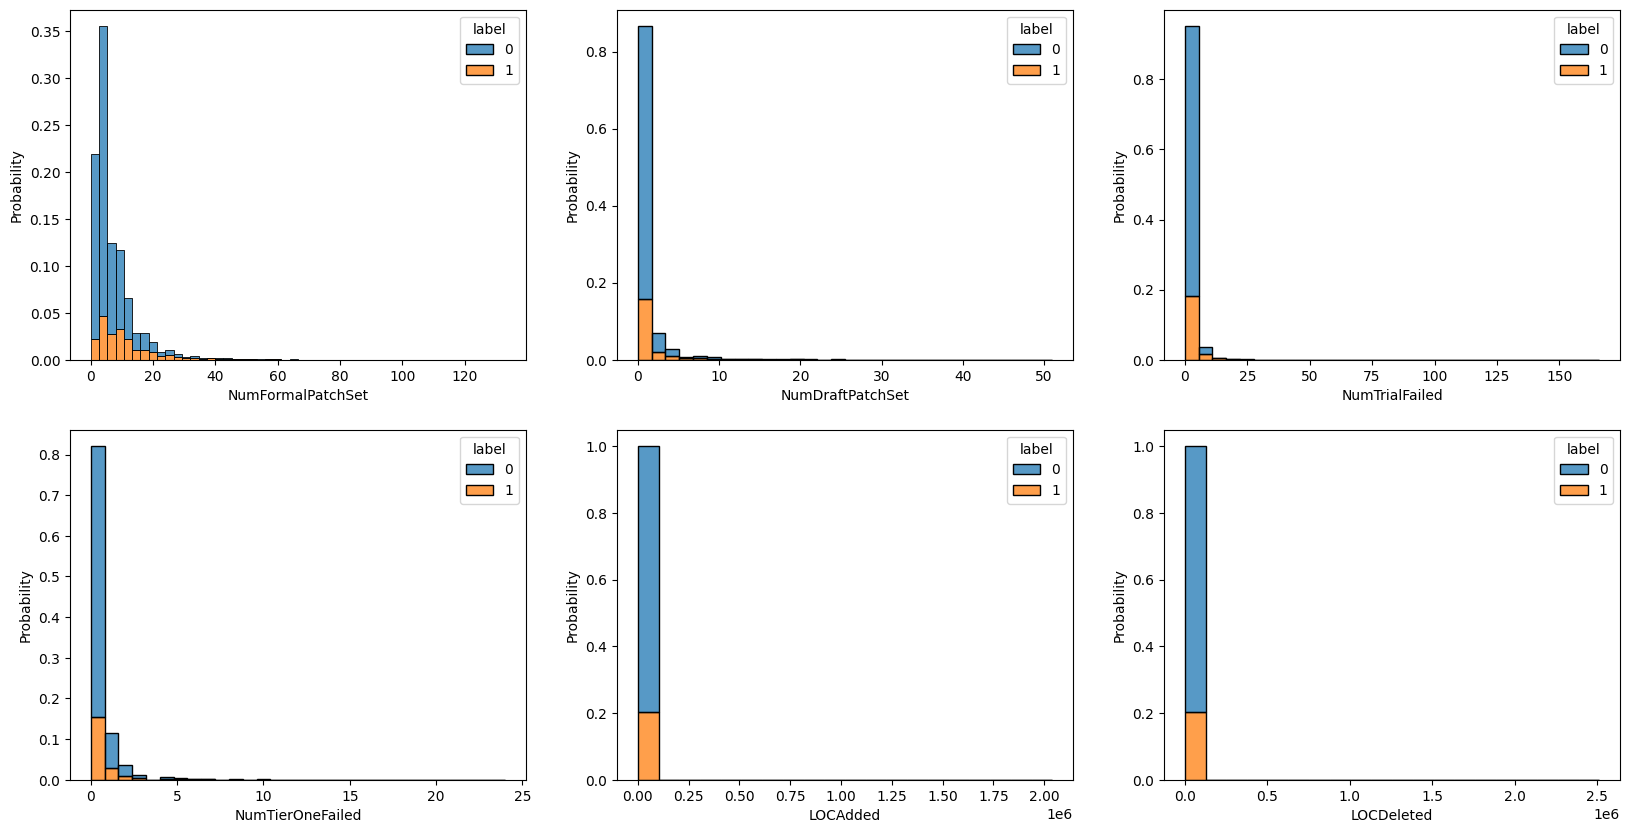

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(data=df, x='NumFormalPatchSet', bins=50, ax=axes[0, 0], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='NumDraftPatchSet', bins=30, ax=axes[0, 1], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='NumTrialFailed', bins=30, ax=axes[0, 2], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='NumTierOneFailed', bins=30, ax=axes[1, 0], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='LOCAdded', bins=20, ax=axes[1, 1], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='LOCDeleted', bins=20, ax=axes[1, 2], hue="label", multiple="stack", stat='probability')

**3.3 Cycle Time Data**

<Axes: xlabel='DaysInCodeReview', ylabel='Probability'>

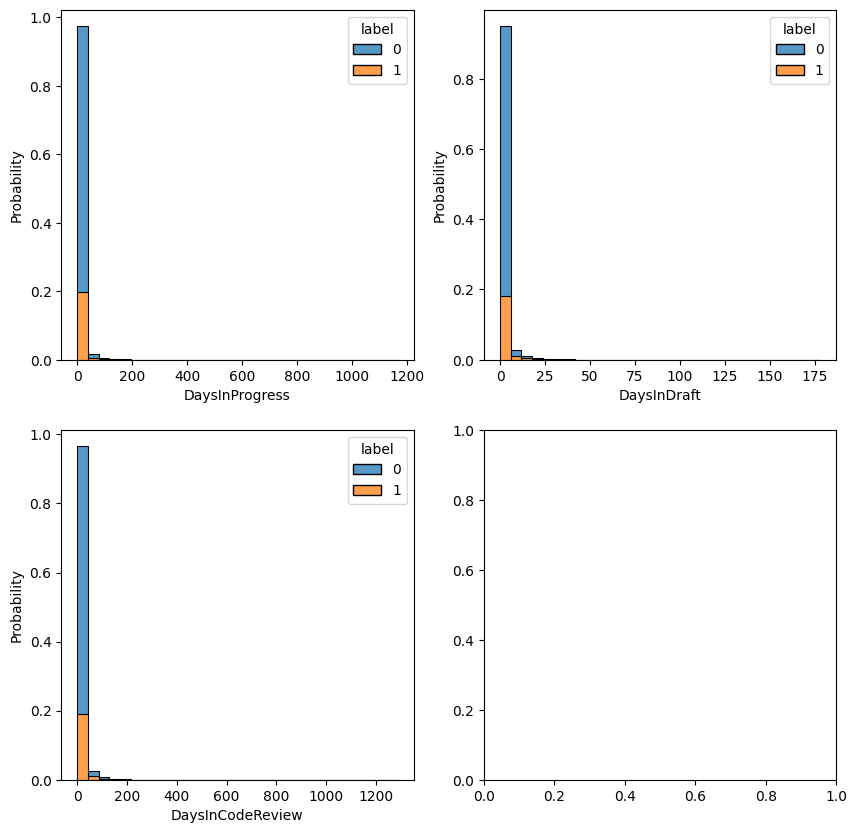

In [14]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sns.histplot(data=df, x='DaysInProgress', bins=30, ax=axes[0, 0], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='DaysInDraft', bins=30, ax=axes[0, 1], hue="label", multiple="stack", stat='probability')
sns.histplot(data=df, x='DaysInCodeReview', bins=30, ax=axes[1, 0], hue="label", multiple="stack", stat='probability')

**3.4 Diffusion Data**

<Axes: xlabel='NumCppChanged', ylabel='Probability'>

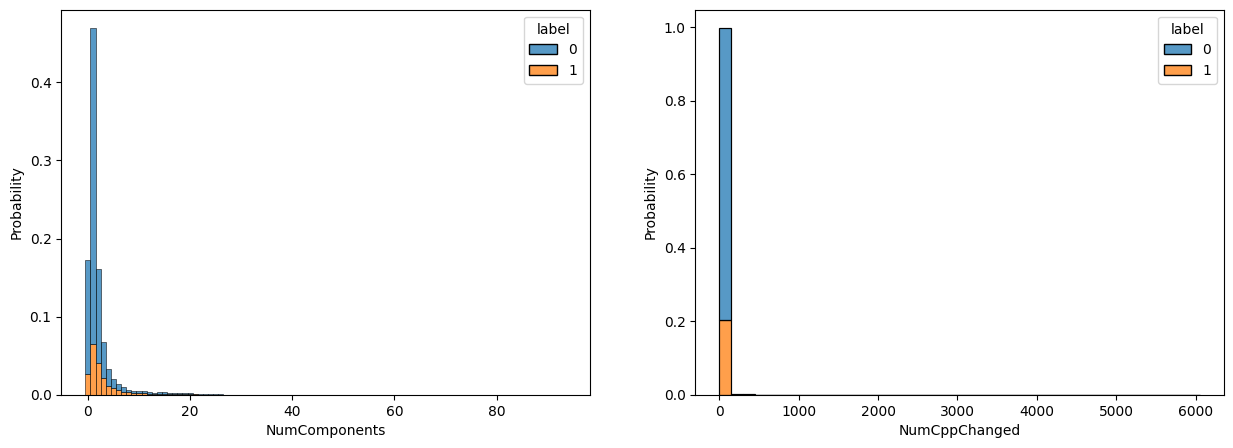

In [15]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=df, x="NumComponents", bins=40, ax=axs[0],hue="label", multiple="stack", discrete=True, stat='probability')
sns.histplot(data=df, x="NumCppChanged", bins=40, ax=axs[1],hue="label", multiple="stack", stat='probability')

**3.5 File History Data**

<Axes: xlabel='AverageAge', ylabel='Probability'>

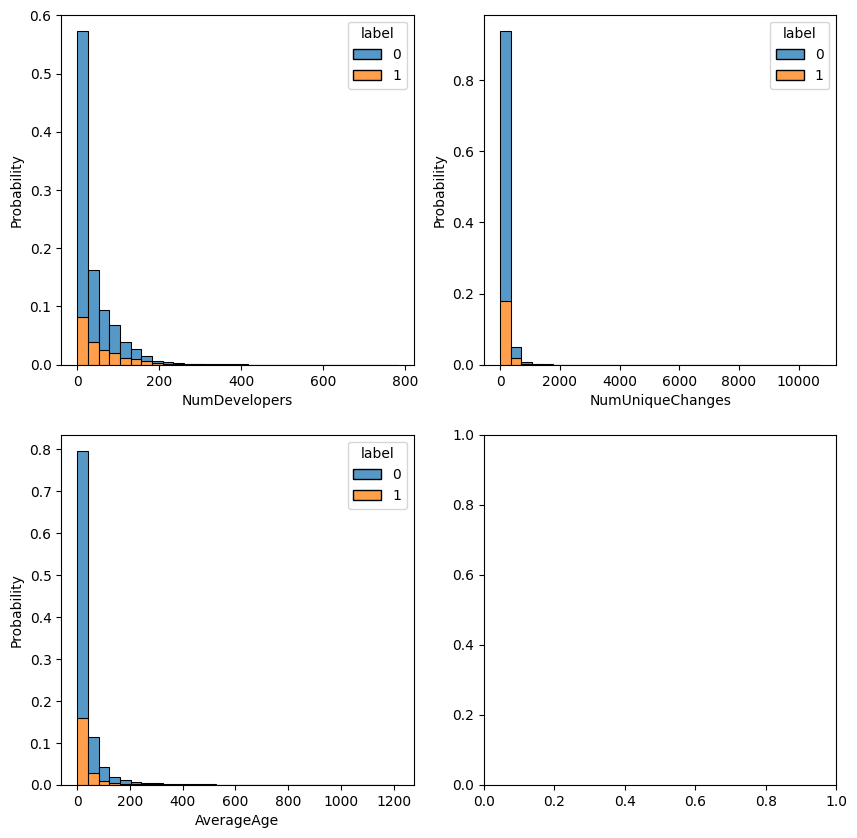

In [16]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

sns.histplot(data=df, x="NumDevelopers", ax=axs[0,0], hue="label", multiple="stack", stat='probability', bins=30)
sns.histplot(data=df, x="NumUniqueChanges", ax=axs[0,1], hue="label", multiple="stack", stat='probability', bins=30)
sns.histplot(data=df, x="AverageAge", ax=axs[1,0], hue="label", multiple="stack", stat='probability', bins=30)

**3.6 Developer Experience**

<Axes: xlabel='ComponentExperience', ylabel='Probability'>

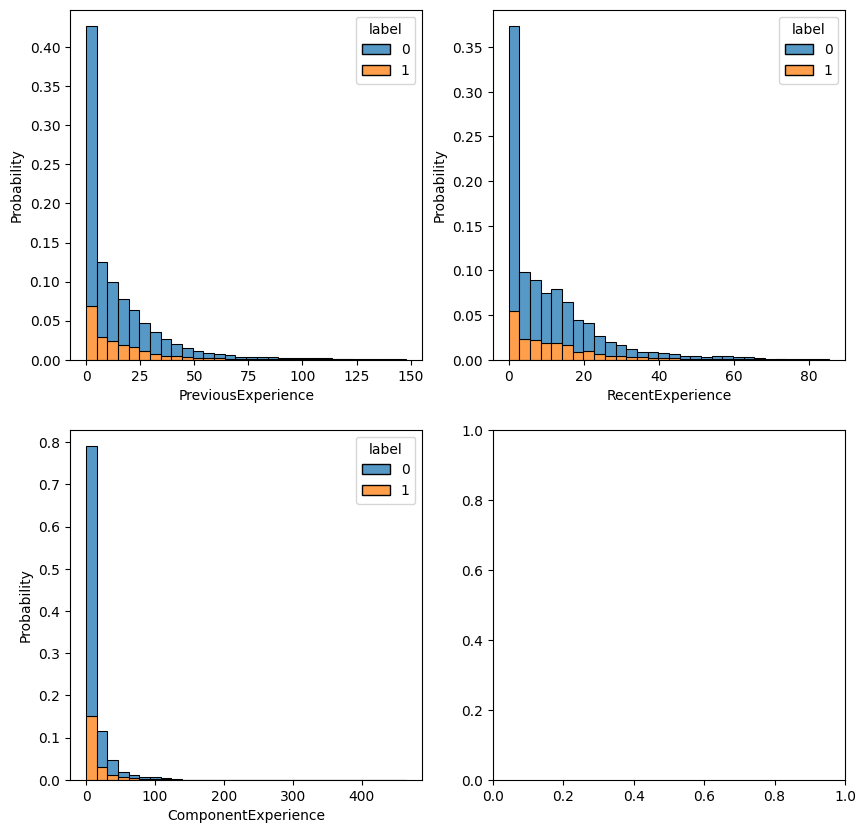

In [17]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

sns.histplot(data=df, x="PreviousExperience", ax=axs[0,0], hue="label", multiple="stack", stat='probability', bins=30)
sns.histplot(data=df, x="RecentExperience", ax=axs[0,1], hue="label", multiple="stack", stat='probability', bins=30)
sns.histplot(data=df, x="ComponentExperience", ax=axs[1,0], hue="label", multiple="stack", stat='probability', bins=30)

**3.7 All Data**

<Axes: >

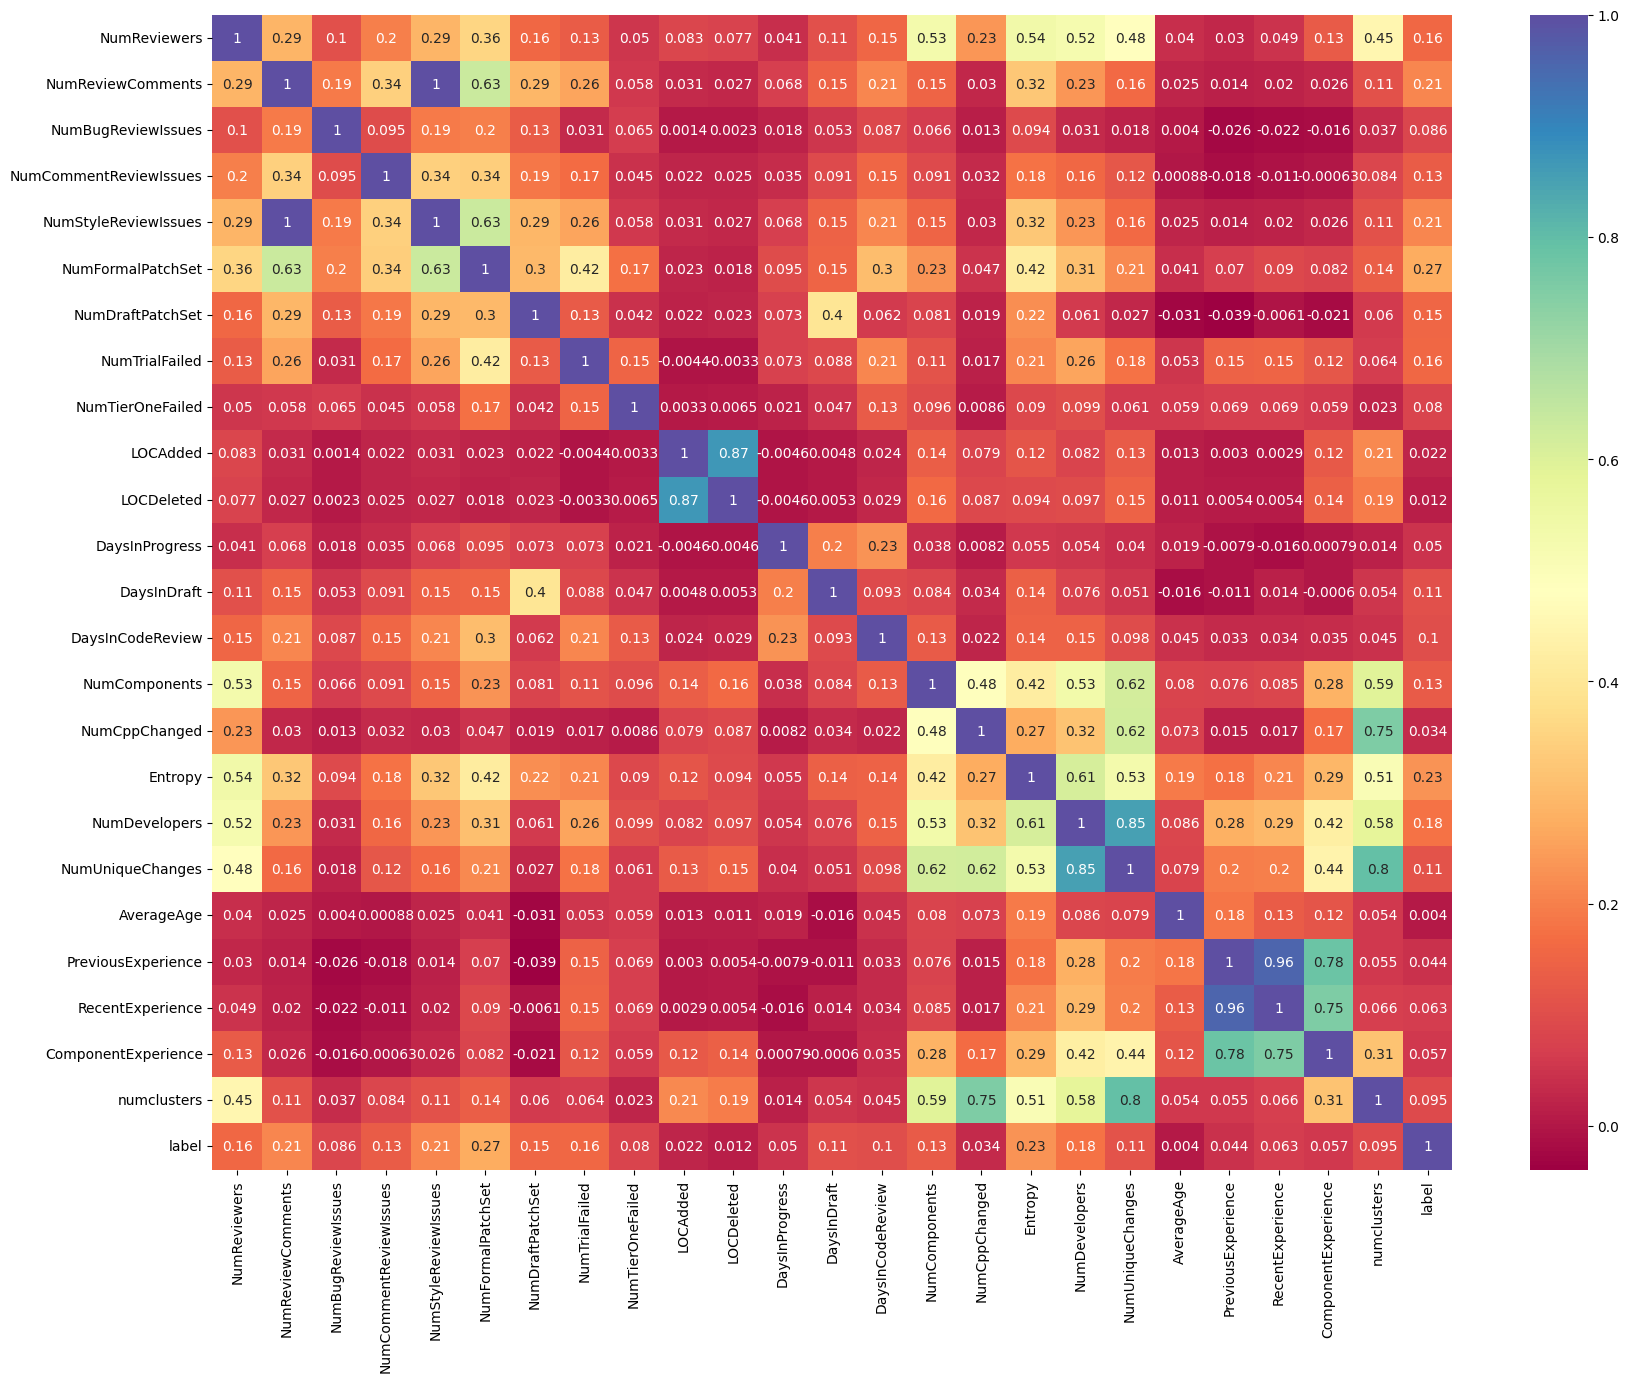

In [38]:
# heatmap of all features to see correlation between them
plt.figure(figsize=(20, 15))

df = df.select_dtypes(include=[float, int]).drop(columns=['ChangeID', 'IssueID', 'ReviewID'])
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='Spectral')

- **Synthesis:** As shown above, there are some features with stronger correlation. This might mean that in the feature selection process later, 
we only need to include one or the other

In [39]:
# for a given change, let's take a look at the statistics
# #Average isn't meaningful here because it can be skewed by the extreme values in the data set 

print(f'The median of developers for a change is {round(df['NumDevelopers'].median(), 2)}.\n')
print(f'The median of changes made by a developer is {round(df['PreviousExperience'].median(), 2)}.\n')
print(f'The median of reviewers for a change is {round(df['NumReviewers'].median(), 2)}.\n')
print(f'The median of components changed for a change is {round(df['NumComponents'].median(), 2)}.\n')
print(f'The median of cpp files touched for a change is {round(df['NumCppChanged'].median(), 2)}.\n')
print(f'The median of comments left on a review for a change is {round(df['NumReviewComments'].median(), 2)}.\n')
print(f'The median of formal patch set for a change is {round(df['NumFormalPatchSet'].median(), 2)}.\n')
print(f'The median of trial one test failed for a change is {round(df['NumTrialFailed'].median(), 2)}.\n')
print(f'The median of tier one test failed for a change is {round(df['NumTierOneFailed'].median(), 2)}.\n')
print(f'The median of lines of code added for a change is {round(df['LOCAdded'].median(), 2)}.\n')
print(f'The median of lines of code deleted for a change is {round(df['LOCAdded'].median(), 2)}.\n')
print(f'The median of number of clusters for a change is {round(df['numclusters'].median(), 2)}.\n')
print(f'The median of days a change was in progress, draft, and code review, respectively is {round(df['DaysInProgress'].median(), 2)}, {round(df['DaysInDraft'].median(), 2)}, {round(df['DaysInCodeReview'].median(), 2)}.\n')

The median of developers for a change is 20.0.

The median of changes made by a developer is 7.0.

The median of reviewers for a change is 6.0.

The median of components changed for a change is 1.0.

The median of cpp files touched for a change is 1.0.

The median of comments left on a review for a change is 1.0.

The median of formal patch set for a change is 5.0.

The median of trial one test failed for a change is 0.0.

The median of tier one test failed for a change is 0.0.

The median of lines of code added for a change is 46.0.

The median of lines of code deleted for a change is 46.0.

The median of number of clusters for a change is 8.0.

The median of days a change was in progress, draft, and code review, respectively is 0.95, 0.0, 6.02.



**Step 4. Creating training and test dataset**

In [84]:
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [42]:
# X is our predictor and Y is our response
X = df.drop(columns=['label'])
y = df['label']

In [53]:
# splitting X and y into training (85%) and testing (15%) dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [54]:
# counting how many values are in our response training and testing dataset
y_train.value_counts()

label
0    11121
1     2852
Name: count, dtype: int64

- **Synthesis:** Around a 1:4 ratio

In [55]:
y_test.value_counts()

label
0    1967
1     499
Name: count, dtype: int64


**Step 5. Model Building**
1. Logistic Regression
2. Naive Bayes
3. KNN
4. Decision Trees
5. SVM
6. NN

In [56]:
# Pre-Model feature selection with random forest classifier
# Feature importance based on mean decrease in GINI impurity
feature_names = feature_names = X_train.columns.tolist()
forest = RandomForestClassifier(random_state=0).fit(X_train, y_train)
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
print(perm_imp_df)


                   Feature  Permutation Importance
23             numclusters                0.006894
16                 Entropy                0.004217
5        NumFormalPatchSet                0.003041
9                 LOCAdded                0.002676
0             NumReviewers                0.002555
15           NumCppChanged                0.001906
22     ComponentExperience                0.001663
1        NumReviewComments                0.001460
2       NumBugReviewIssues                0.001014
8         NumTierOneFailed                0.000527
11          DaysInProgress                0.000406
3   NumCommentReviewIssues                0.000365
18        NumUniqueChanges                0.000122
6         NumDraftPatchSet               -0.000081
14           NumComponents               -0.000081
10              LOCDeleted               -0.000203
7           NumTrialFailed               -0.000324
19              AverageAge               -0.000446
13        DaysInCodeReview     

In [57]:
# Selected features. Not all features are used to reduce dimensions of dataset & preserve computation speed
selected = ['LOCAdded', 'DaysInProgress', 'NumReviewers', 'NumDraftPatchSet', 'NumCppChanged', 
            'NumFormalPatchSet', 'NumUniqueChanges', 'DaysInDraft', 'NumDevelopers', 'numclusters',
           'NumComponents', 'PreviousExperience']

X_train = X_train[selected]
X_test = X_test[selected]


In [70]:
# Standardize features by removing the mean and scaling to unit variance
# The standard score of a sample x is calculated as:
# z = (x - u) / s
# where u is the mean of the training samples, and s is the standard deviation of the training samples.
# Attempts to correct the right skewness of our dataset to be approximately distributed normally
scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_normalized, columns=X_test.columns, index=X_test.index)

**5.1 Logistic Regression**

In [71]:
# Setting up a weighted logistic regression model to optimize for recall performance
weights = {0:1.0, 1:5.5}
logreg = LogisticRegression(max_iter=2000, class_weight= weights)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

**5.1.5 Logistic Regression Performance Evaluation**

In [75]:
# Setting up a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1103,  864],
       [ 122,  377]])

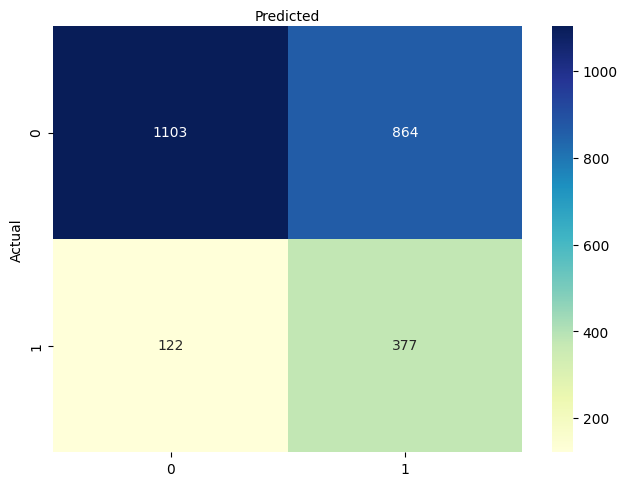

In [76]:
# Function to pretty print the confusion matrix. Made to reuse for other models later
def print_cnf_matrix(cnf):
    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

print_cnf_matrix(cnf_matrix)

- **Synthesis:**
    - True Negative (1102): The model predicts that the change is clean, the change is actually clean
    - False Negative (123): The model predicts that the change is clean, the change is actually buggy
    - False Positive (865): The model predicts that the change is buggy, the change is actually clean 
    - True Positive (376): The model predicts that the change is buggy, the change is actually buggy

In [73]:
# Building a text report showing the main classification metrics. Function for reuse
target_names = ['clean', 'buggy']

def print_class_report(y_pred):  
    print(classification_report(y_test, y_pred, target_names=target_names))

print_class_report(y_pred)

              precision    recall  f1-score   support

       clean       0.90      0.56      0.69      1967
       buggy       0.30      0.76      0.43       499

    accuracy                           0.60      2466
   macro avg       0.60      0.66      0.56      2466
weighted avg       0.78      0.60      0.64      2466



- **Synthesis:** Since the model was optimized to predict buggy changes, the recall is higher at 76%. However, the f-1 score (43%)
shows that there was a trade off in precision (30%). 

- **Connection to problem:** The model has a tendency to raise false alarms which may lead to frustration with developers that have to recheck their clean code. 

In [77]:
# Getting model probabilities
probabilities = logreg.predict_proba(X_test)
probabilities

array([[0.34749596, 0.65250404],
       [0.62302848, 0.37697152],
       [0.4101828 , 0.5898172 ],
       ...,
       [0.36572747, 0.63427253],
       [0.54697704, 0.45302296],
       [0.10530057, 0.89469943]], shape=(2466, 2))

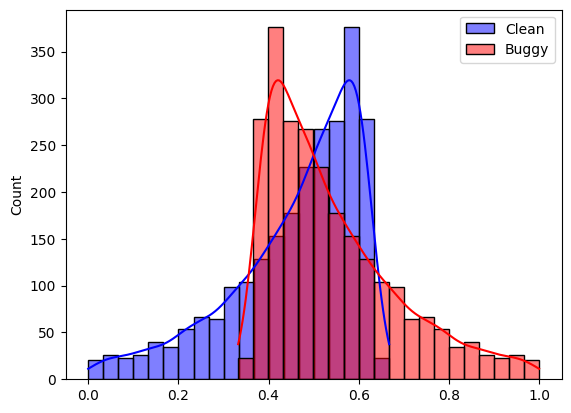

In [80]:
# Plotting probabilities for both classes
sns.histplot(probabilities[:, 0], bins=20, color='blue', label='Clean', kde=True)
sns.histplot(probabilities[:, 1], bins=20, color='red', label='Buggy', kde=True)
plt.legend()


- **Synthesis:** The model is slightly more confident in predicting clean changes since the kde peaks around 0.6 for clean changes vs 0.4 for buggy changes.


**5.2 Naive Bayes**

In [88]:
from sklearn.naive_bayes import GaussianNB

In [89]:
"""
uses Bayes’ Theorem to classify data based on the probabilities of different classes given the features of the data. 
Posterior = Likelihood × Prior ÷ Evidence
"""
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [90]:
y_pred = gnb.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1836,  131],
       [ 390,  109]])

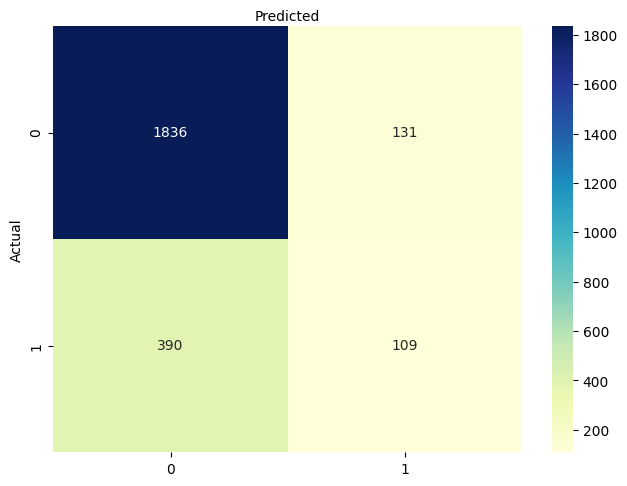

In [91]:
print_cnf_matrix(cnf_matrix)

In [92]:
print_class_report(y_pred)

              precision    recall  f1-score   support

       clean       0.82      0.93      0.88      1967
       buggy       0.45      0.22      0.29       499

    accuracy                           0.79      2466
   macro avg       0.64      0.58      0.59      2466
weighted avg       0.75      0.79      0.76      2466



**KNN**

In [93]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [94]:
y_pred = knn.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1879,   88],
       [ 440,   59]])

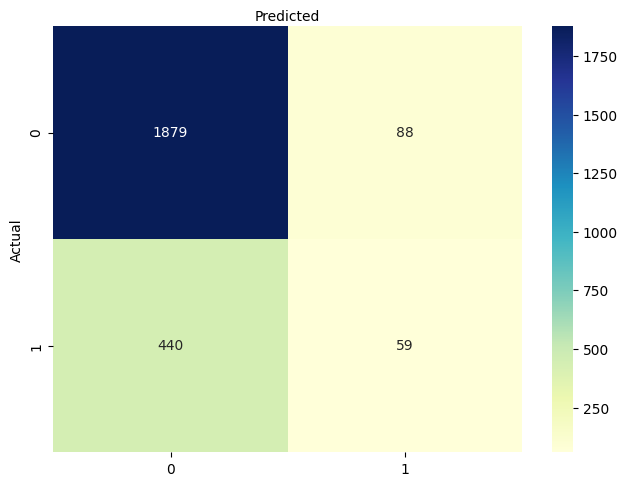

In [95]:
print_cnf_matrix(cnf_matrix)

In [96]:
print_class_report(y_pred)

              precision    recall  f1-score   support

       clean       0.81      0.96      0.88      1967
       buggy       0.40      0.12      0.18       499

    accuracy                           0.79      2466
   macro avg       0.61      0.54      0.53      2466
weighted avg       0.73      0.79      0.74      2466



**Decision Tree**

In [97]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
dt

DecisionTreeClassifier()

In [98]:
y_pred = dt.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1599,  368],
       [ 329,  170]])

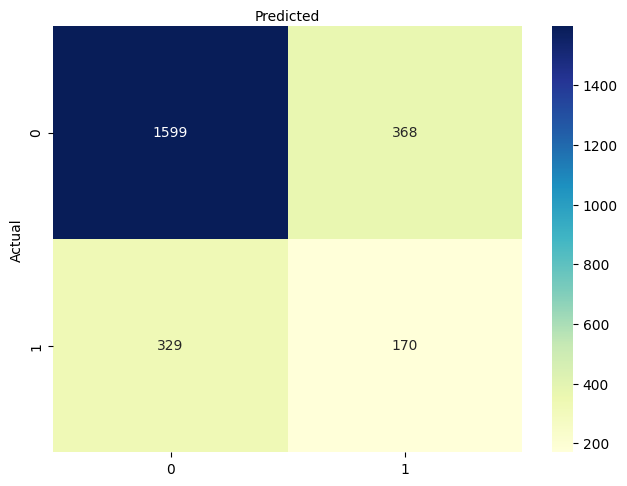

In [99]:
print_cnf_matrix(cnf_matrix)

In [100]:
print_class_report(y_pred)

              precision    recall  f1-score   support

       clean       0.83      0.81      0.82      1967
       buggy       0.32      0.34      0.33       499

    accuracy                           0.72      2466
   macro avg       0.57      0.58      0.57      2466
weighted avg       0.73      0.72      0.72      2466



**SVM**

In [101]:
from sklearn.svm import SVC

svm = SVC(class_weight = weights)
svm.fit(X_train, y_train)
svm

SVC(class_weight={0: 1.0, 1: 5.5})

In [102]:
y_pred = svm.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1124,  843],
       [ 125,  374]])

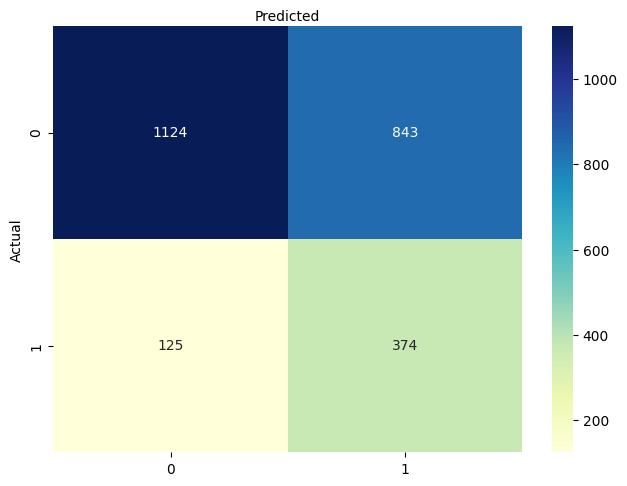

In [103]:
print_cnf_matrix(cnf_matrix)

In [105]:
print_class_report(y_pred)

              precision    recall  f1-score   support

       clean       0.90      0.57      0.70      1967
       buggy       0.31      0.75      0.44       499

    accuracy                           0.61      2466
   macro avg       0.60      0.66      0.57      2466
weighted avg       0.78      0.61      0.65      2466



**Neural Network**

In [106]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(max_iter = 4000)
nn.fit(X_train, y_train)
nn

MLPClassifier(max_iter=4000)

In [107]:
y_pred = nn.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1898,   69],
       [ 406,   93]])

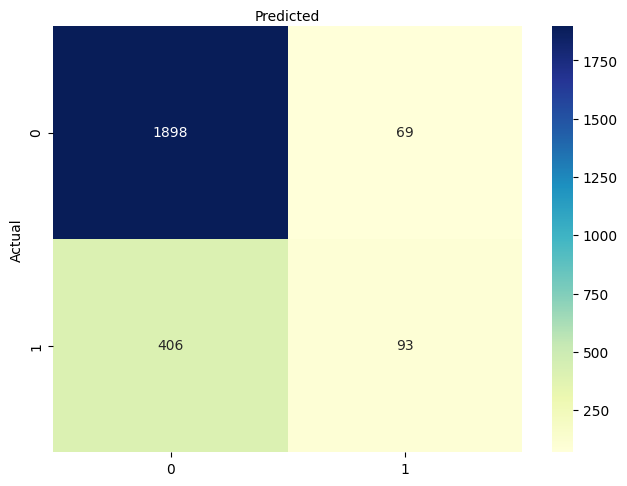

In [108]:
print_cnf_matrix(cnf_matrix)

In [109]:
print_class_report(y_pred)

              precision    recall  f1-score   support

       clean       0.82      0.96      0.89      1967
       buggy       0.57      0.19      0.28       499

    accuracy                           0.81      2466
   macro avg       0.70      0.58      0.59      2466
weighted avg       0.77      0.81      0.77      2466



**Step 6. CodeScene**

**What is it**

[From Wikipedia]

CodeScene is a software engineering intelligence platform that combines code quality metrics with behavioral code analysis. It provides visualizations based on version control data and machine learning algorithms that identify social patterns and hidden risks in source code.

CodeScene offers several features that support software maintainability and evolution within large-scale software development environments. The platform delivers several actionable performance indicators that assist software organizations in identifying risks and bottlenecks.

**Motivation**
Our motivation is to compare the performance of Codescene's model and our model


In [112]:
# Setting up a df for codescene
codescenedf = pd.read_csv("OneDrive - Western Digital/CodeSceneData.csv")

In [113]:
codescenedf.head()

,ChangeID,RiskNum,label
0,52617,1,0
1,52632,2,0
2,52635,3,1
3,52668,3,0
4,52682,1,0


In [115]:
# Length of codescene's df
len(codescenedf)

12423

In [116]:
# Length of our df
len(df)

16439

In [135]:
# Splitting up the dataset
cs_X = codescenedf.drop(columns=['label', 'ChangeID'])
cs_y = codescenedf['label']

<Axes: xlabel='RiskNum', ylabel='Probability'>

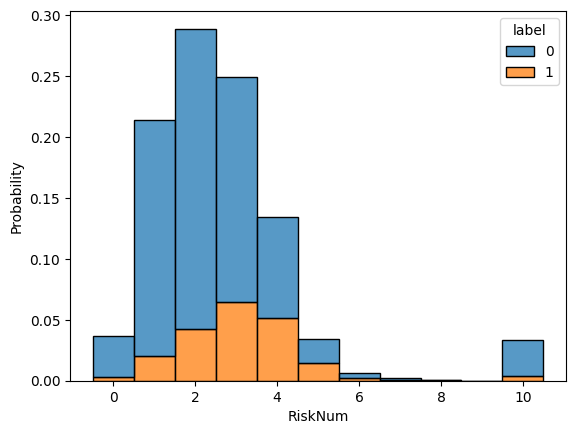

In [136]:
sns.histplot(data=codescenedf, x="RiskNum", hue="label", multiple="stack", stat='probability', discrete=True, bins=10)

In [143]:
csX_train, csX_test, csy_train, csy_test = train_test_split(cs_X, cs_y, test_size = 0.2, random_state=0)

In [144]:
scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(csX_train)
X_test_normalized = scaler.transform(csX_test)

csX_train = pd.DataFrame(X_train_normalized, columns=csX_train.columns, index=csX_train.index)
csX_test = pd.DataFrame(X_test_normalized, columns=csX_test.columns, index=csX_test.index)

In [145]:
# Usi
logreg = LogisticRegression(max_iter=2000, class_weight= weights)

logreg.fit(csX_train, csy_train)
csy_pred = logreg.predict(csX_test)

In [146]:
cnf_matrix = metrics.confusion_matrix(csy_test, csy_pred)
cnf_matrix

array([[ 559, 1424],
       [  59,  443]])

In [150]:
print(classification_report(csy_test, csy_pred, target_names=target_names))

              precision    recall  f1-score   support

       clean       0.90      0.28      0.43      1983
       buggy       0.24      0.88      0.37       502

    accuracy                           0.40      2485
   macro avg       0.57      0.58      0.40      2485
weighted avg       0.77      0.40      0.42      2485



- **Synthesis:** Though Codescene's recall (88%) was higher, their f-1 score was 7% percent lower than our best performing model.